In [ ]:
# import all dependencies and assignment of env variables
import os
import requests
from bs4 import BeautifulSoup
import yfinance as yf
from datetime import datetime, timedelta
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
import torch
import openai
from dotenv import load_dotenv
# Configuration
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
assert openai.api_key is not None
BASE_URL = "https://www.federalreserve.gov"
CALENDAR_URL = f"{BASE_URL}/monetarypolicy/fomccalendars.htm"
START_YEAR = 2022
OUTPUT_DIR = "minutes_texts"
print('Done Loading Libraries!!!!')

In [ ]:
# Load FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
print('Done Loading Models')

In [18]:
# Functions
def get_finbert_sentiment(text, chunk_size=512):
    #Get FinBERT sentiment scores for text
    # Split text into chunks to handle long documents
    words = text.split()
    chunks = [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
    sentiment_scores = []
    for chunk in chunks:
        inputs = tokenizer(chunk, return_tensors="pt", truncation=True, max_length=512)
        outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=1)
        sentiment_scores.append(scores.detach().numpy()[0])
    avg_scores = np.mean(sentiment_scores, axis=0)
    return {'positive': float(avg_scores[0]),'negative': float(avg_scores[1]),'neutral': float(avg_scores[2])}

def scrape_and_save_minutes():
    #Scrape FOMC minutes and save them to text files
    try:
        print("Fetching FOMC calendar page...")
        response = requests.get(CALENDAR_URL)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        panels = soup.find_all('div', class_='panel-default')
        minutes_dict = {}
        for panel in panels:
            heading = panel.find('div', class_='panel-heading')
            if not heading: continue
            year_match = re.search(r'(\d{4})', heading.get_text())
            if not year_match: continue
            year = int(year_match.group(1))
            if year < START_YEAR: continue
            print(f"\nProcessing year {year}...")
            meeting_rows = panel.find_all('div', class_='fomc-meeting')
            print(f"Found {len(meeting_rows)} meeting rows")
            for row in meeting_rows:
                minutes_div = row.find('div', class_='fomc-meeting__minutes')
                if not minutes_div: continue
                links = minutes_div.find_all('a')
                html_link = next((link for link in links if 'htm' in link.get('href', '').lower()), None)
                if html_link and html_link.get('href'):
                    full_url = f"{BASE_URL}{html_link['href']}"
                    date = re.search(r'minutes(\d{8})', full_url)
                    if date:
                        date_str = date.group(1)
                        formatted_date = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"
                        print(f"Fetching minutes from {formatted_date}")
                        response = requests.get(full_url)
                        response.raise_for_status()
                        soup = BeautifulSoup(response.text, 'html.parser')
                        article = soup.find('div', id='article')
                        if article:
                            paragraphs = article.find_all('p')
                            text = ' '.join(p.get_text(strip=True) for p in paragraphs)
                            if text:
                                minutes_dict[formatted_date] = (full_url, text)
                                os.makedirs(OUTPUT_DIR, exist_ok=True)
                                with open(os.path.join(OUTPUT_DIR, f"minutes_{formatted_date}.txt"), 'w', encoding='utf-8') as f:
                                    f.write(text)
                                print(f"Saved minutes for {formatted_date} ({len(text)} characters)")
                                time.sleep(1)
        print(f"\nAvailable dates:")
        for date in sorted(minutes_dict.keys()):
            url, text = minutes_dict[date]
            print(f"{date}: {len(text)} characters")
        print('Finished Scraping')
        return minutes_dict
    except requests.RequestException as e:
        print(f"Error: {e}")
        return {}

def analyze_minutes_and_yields():
    #Analyze minutes sentiment and yield changes [positive, negative, neutral]
    hawkish_mapping = np.array([1, -0.5, 0])  # positive sentiment more hawkish
    sentiment_results,yield_results = {},{}
    # Calculate sentiment scores for all documents
    for filename in os.listdir(OUTPUT_DIR):
        if filename.startswith("minutes_") and filename.endswith(".txt"):
            print(f"Reading: {filename}")
            date = filename[8:-4]
            with open(os.path.join(OUTPUT_DIR, filename), 'r', encoding='utf-8') as f:
                text = f.read()
            # Get FinBERT sentiment scores as array
            scores = get_finbert_sentiment(text)
            scores_array = np.array([scores['positive'], scores['negative'], scores['neutral']])
            # Calculate hawkish score using dot product => This will give a score between -1 and 1
            hawkish_score = np.dot(scores_array, hawkish_mapping)
            sentiment_results[date] = hawkish_score
    # Calculate yield changes
    for date in sentiment_results.keys():
        try:
            start_date = datetime.strptime(date, '%Y-%m-%d')
            end_date = start_date + timedelta(days=7)
            print(f"Fetching yields for {date}...")
            data = yf.download('^TNX', start=start_date, end=end_date, progress=False)
            if not data.empty:
                initial_yield = float(data['Close'].iloc[0])  # Convert to float
                final_yield = float(data['Close'].iloc[-1])   # Convert to float
                yield_results[date] = round(final_yield - initial_yield, 2)
                print(f"Successfully got yield change")
            else:
                print(f"No yield data available for {date}")
                yield_results[date] = None
        except Exception as e:
            print(f"Error getting yield data for {date}: {e}")
            yield_results[date] = None
    df = pd.DataFrame({'Hawkish Score': sentiment_results,'10Y_Change': yield_results}).sort_index()
    print("FOMC Minutes Analysis")
    print("=" * 80)
    print(df)
    # Create scatter plot
    if not df['10Y_Change'].isna().all():
        plt.figure(figsize=(10, 6))
        valid_data = df.dropna()
        if not valid_data.empty:
            sns.scatterplot(data=valid_data, x='Hawkish Score', y='10Y_Change')
            plt.title('Hawkish Score vs 10Y Treasury Yield Change')
            plt.xlabel('Hawkish Score (-1 = Dove, 1 = Hawk)')
            plt.ylabel('10Y Yield Change (bps)')
            x = valid_data['Hawkish Score']
            y = valid_data['10Y_Change']
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            plt.plot(x, p(x), "r--", alpha=0.8)
            correlation = valid_data['Hawkish Score'].corr(valid_data['10Y_Change'])
            plt.annotate(f'Correlation: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))
            plt.tight_layout()
            plt.savefig('corr.png', dpi=300, bbox_inches='tight')
            plt.show()
    return df


def evaluate_sentiment_predictions(df, hs_low, hs_high, y_low, y_high):
    eval_df = df.copy()
    eval_df.dropna(subset=['Hawkish Score', '10Y_Change'], inplace=True)
    if eval_df.empty:
        print("No data available for evaluation.")
        return
    # Predicted: based on Hawkish Score # Actual: based on Yield Change
    eval_df['Predicted_Label'] = np.select([eval_df['Hawkish Score'] < hs_low,eval_df['Hawkish Score'] > hs_high],[0, 1],default=2)
    eval_df['Actual_Label'] = np.select([eval_df['10Y_Change'] < y_low,eval_df['10Y_Change'] > y_high],[0, 1],default=2)
    cm_labels = [0, 1, 2]  # Dovish, Hawkish, Neutral
    cm = confusion_matrix(eval_df['Actual_Label'], eval_df['Predicted_Label'], labels=cm_labels)
    accuracy = accuracy_score(eval_df['Actual_Label'], eval_df['Predicted_Label'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Dovish (0)', 'Hawkish (1)', 'Neutral (2)'],yticklabels=['Dovish (0)', 'Hawkish (1)', 'Neutral (2)'],cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(f'Sentiment Classification Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
    plt.savefig('conf_matr.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


def plot_distribution_with_std(df, column, sd, color='blue'):
    data = df[column].dropna()
    mean_val = data.mean()
    std_val = data.std()
    lower_limit = mean_val - sd * std_val
    upper_limit = mean_val + sd * std_val
    plt.figure(figsize=(7, 5))
    sns.histplot(data, bins=20, color=color)
    plt.axvline(mean_val, color='black', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axvline(lower_limit, color='red', linestyle='--', label=f'-{sd} Std Dev: {lower_limit:.2f}')
    plt.axvline(upper_limit, color='green', linestyle='--', label=f'+{sd} Std Dev: {upper_limit:.2f}')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.savefig(column[:5]+'_hist.png', dpi=300, bbox_inches='tight')
    plt.show()
    return mean_val, std_val, lower_limit, upper_limit

def query_minutes_OpenAI(date, question, model="gpt-3.5-turbo", max_tokens=500):
    filename = f"minutes_texts/minutes_{date}.txt"
    if not os.path.exists(filename):
        return f"File for date {date} not found: {filename}"
    with open(filename, "r", encoding="utf-8") as file:
        minutes_text = file.read()
    prompt = (
        f"You are a financial analyst. Based on the FOMC minutes from {date}, "
        f"answer the following question:\n\n{question}\n\n"
        f"---\nFOMC Minutes:\n{minutes_text}")
    try:
        response = openai.ChatCompletion.create(
            model=model,
            messages=[{"role": "system", "content": "You are a helpful financial analyst."},{"role": "user", "content": prompt}],max_tokens=max_tokens,temperature=0.3)
        return response.choices[0].message['content'].strip()
    except Exception as e:
        return f"Error querying OpenAI API: {e}"


print('Done with Functions')

Done with Functions


In [ ]:
# Scrap minutes from the web:
minutes_dict = scrape_and_save_minutes()  # Only needed first time or to update

Reading: minutes_2023-12-13.txt
Reading: minutes_2023-07-26.txt
Reading: minutes_2023-02-01.txt
Reading: minutes_2023-09-20.txt
Reading: minutes_2022-01-26.txt
Reading: minutes_2024-01-31.txt
Reading: minutes_2024-03-20.txt
Reading: minutes_2022-06-15.txt
Reading: minutes_2024-06-12.txt
Reading: minutes_2024-09-18.txt
Reading: minutes_2022-07-27.txt
Reading: minutes_2025-03-19.txt
Reading: minutes_2023-03-22.txt
Reading: minutes_2022-09-21.txt
Reading: minutes_2022-12-14.txt
Reading: minutes_2023-06-14.txt
Reading: minutes_2024-07-31.txt
Reading: minutes_2023-11-01.txt
Reading: minutes_2025-01-29.txt
Reading: minutes_2022-05-04.txt
Reading: minutes_2024-12-18.txt
Reading: minutes_2024-05-01.txt
Reading: minutes_2024-11-07.txt
Reading: minutes_2023-05-03.txt
Reading: minutes_2022-11-02.txt
Reading: minutes_2025-05-07.txt
Reading: minutes_2022-03-16.txt
Fetching yields for 2023-12-13...


/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_yield = float(data['Close'].iloc[0])  # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_yield = float(data['Close'].iloc[-1])   # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_yield = float(data['Close'].iloc[0])  # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:97: FutureWarning: Calling float on a single e

Successfully got yield change
Fetching yields for 2023-07-26...
Successfully got yield change
Fetching yields for 2023-02-01...
Successfully got yield change
Fetching yields for 2023-09-20...
Successfully got yield change
Fetching yields for 2022-01-26...
Successfully got yield change
Fetching yields for 2024-01-31...
Successfully got yield change
Fetching yields for 2024-03-20...


/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_yield = float(data['Close'].iloc[0])  # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_yield = float(data['Close'].iloc[-1])   # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_yield = float(data['Close'].iloc[0])  # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:97: FutureWarning: Calling float on a single e

Successfully got yield change
Fetching yields for 2022-06-15...
Successfully got yield change
Fetching yields for 2024-06-12...
Successfully got yield change
Fetching yields for 2024-09-18...
Successfully got yield change
Fetching yields for 2022-07-27...
Successfully got yield change
Fetching yields for 2025-03-19...


/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_yield = float(data['Close'].iloc[0])  # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_yield = float(data['Close'].iloc[-1])   # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_yield = float(data['Close'].iloc[0])  # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:97: FutureWarning: Calling float on a single e

Successfully got yield change
Fetching yields for 2023-03-22...
Successfully got yield change
Fetching yields for 2022-09-21...
Successfully got yield change
Fetching yields for 2022-12-14...
Successfully got yield change
Fetching yields for 2023-06-14...


/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_yield = float(data['Close'].iloc[0])  # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_yield = float(data['Close'].iloc[-1])   # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_yield = float(data['Close'].iloc[0])  # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:97: FutureWarning: Calling float on a single e

Successfully got yield change
Fetching yields for 2024-07-31...
Successfully got yield change
Fetching yields for 2023-11-01...
Successfully got yield change
Fetching yields for 2025-01-29...
Successfully got yield change
Fetching yields for 2022-05-04...
Successfully got yield change
Fetching yields for 2024-12-18...


/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_yield = float(data['Close'].iloc[0])  # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_yield = float(data['Close'].iloc[-1])   # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_yield = float(data['Close'].iloc[0])  # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:97: FutureWarning: Calling float on a single e

Successfully got yield change
Fetching yields for 2024-05-01...
Successfully got yield change
Fetching yields for 2024-11-07...
Successfully got yield change
Fetching yields for 2023-05-03...
Successfully got yield change
Fetching yields for 2022-11-02...
Successfully got yield change
Fetching yields for 2025-05-07...


/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_yield = float(data['Close'].iloc[0])  # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_yield = float(data['Close'].iloc[-1])   # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_yield = float(data['Close'].iloc[0])  # Convert to float
/var/folders/gx/kv0x8css2qjd8wt2ljm_5x700000gn/T/ipykernel_30115/163826693.py:97: FutureWarning: Calling float on a single e

Successfully got yield change
Fetching yields for 2022-03-16...
Successfully got yield change
FOMC Minutes Analysis
            Hawkish Score  10Y_Change
2022-01-26      -0.037644       -0.05
2022-03-16       0.051560        0.18
2022-05-04       0.121729        0.08
2022-06-15      -0.054365       -0.09
2022-07-27      -0.109930        0.01
2022-09-21       0.018960        0.45
2022-11-02      -0.034013        0.07
2022-12-14      -0.093547        0.18
2023-02-01      -0.089430        0.28
2023-03-22      -0.104105        0.06
2023-05-03      -0.065866        0.12
2023-06-14       0.131706       -0.07
2023-07-26       0.052888        0.20
2023-09-20       0.077411        0.21
2023-11-01      -0.004124       -0.22
2023-12-13      -0.205616       -0.11
2024-01-31      -0.136254        0.12
2024-03-20       0.091404       -0.04
2024-05-01       0.078670       -0.13
2024-06-12      -0.124901       -0.08
2024-07-31      -0.134720       -0.22
2024-09-18      -0.200150        0.05
2024-11-07

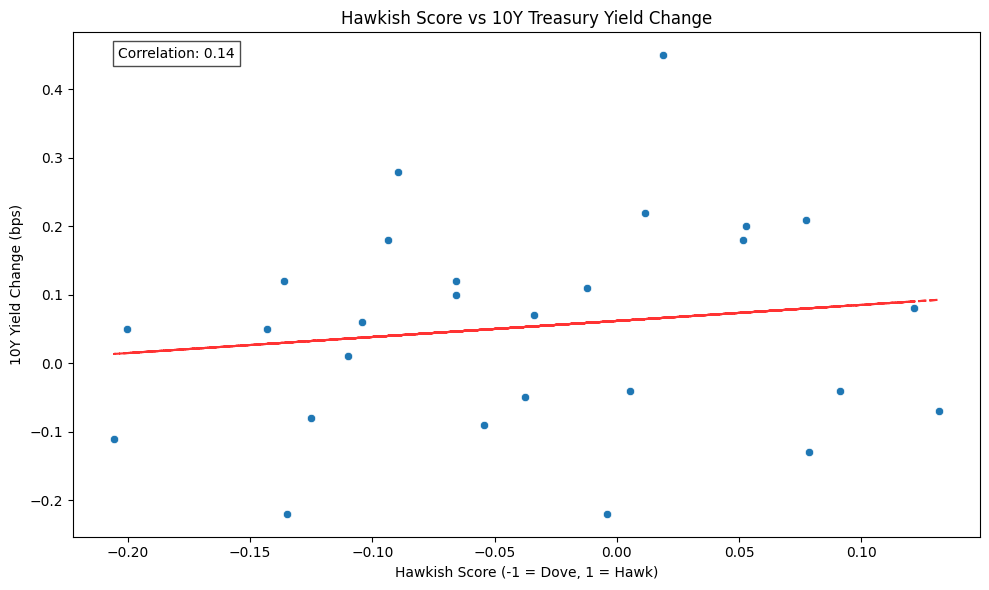

In [16]:
# Analyse (minutes text retrieved before) => Dovish/Hawkish SCORE => plots against US yields
df=analyze_minutes_and_yields()

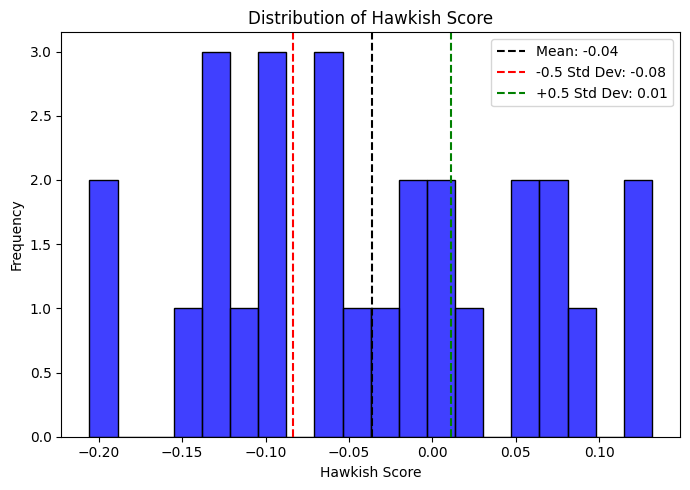

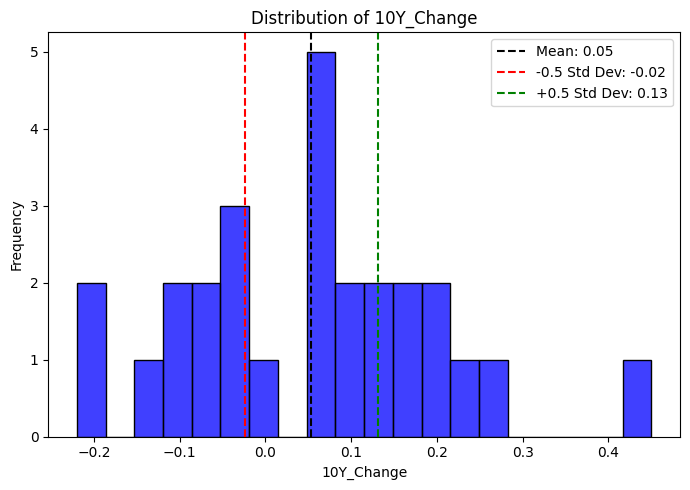

In [19]:
# Plots distribution of Hawk_Score & 10y changes
_, _, hs_low, hs_high = plot_distribution_with_std(df, 'Hawkish Score', 0.5)
_, _, y_low, y_high = plot_distribution_with_std(df, '10Y_Change', 0.5)

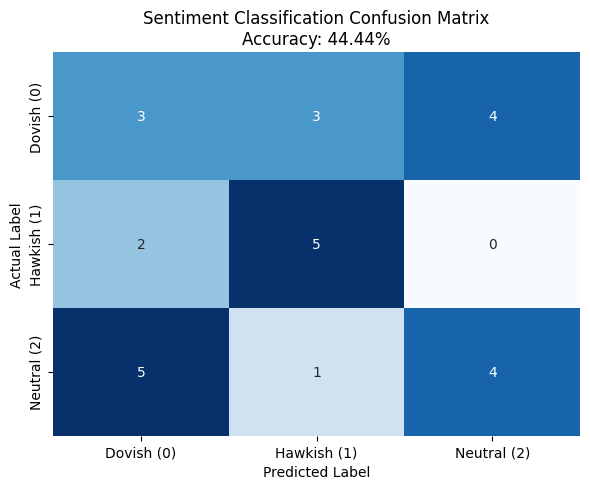

In [20]:
# Evaluate classification (of Dovish/Hawkish) 0 = Dovish ; 1 = Hawkish ; 2 = Neutral (if within limits)
eval_df=evaluate_sentiment_predictions(df, hs_low, hs_high, y_low, y_high)

In [21]:
# LLM query
date_query="2025-05-07"
ques="What was the Fed's outlook on inflation?"
response = query_minutes_OpenAI(date_query, ques, model='gpt-4o-mini')
print(response)
print(df.loc[date_query])


The Federal Reserve's outlook on inflation, as discussed in the FOMC minutes from May 6-7, 2025, indicates that inflation remains somewhat elevated, with a current total consumer price inflation rate of 2.3% and core inflation at 2.6%. While these figures are lower than their year-earlier levels, participants noted that inflation had eased significantly since its peak in 2022 but still exceeds the Committee's longer-run goal of 2%.

Participants expressed concerns that recent tariff increases could lead to a boost in inflation, with many firms planning to pass on these cost increases to consumers. There is also uncertainty regarding the persistence of inflation, as some participants noted that short-term inflation expectations have increased and could lead to more firms raising prices. Although longer-term inflation expectations remain well anchored, there is a risk that they could drift upward, contributing to further inflationary pressures.

Overall, the Fed's outlook reflects a caut